In [1]:
import numpy as np

vggt_info = np.load("/workspace/data/vggt_npy/run_3.npz", allow_pickle=True)

In [2]:
vggt_info.keys()

KeysView(NpzFile '/workspace/data/vggt_npy/run_3.npz' with keys: x3d_pose, camera_intrinsics, R, t, C)

In [3]:
for k, v in vggt_info.items():
	print(k, type(v), v.shape if isinstance(v, np.ndarray) else '')

x3d_pose <class 'numpy.ndarray'> (360, 17, 3)
camera_intrinsics <class 'numpy.ndarray'> (360, 2, 3, 3)
R <class 'numpy.ndarray'> (360, 2, 3, 3)
t <class 'numpy.ndarray'> (360, 2, 3)
C <class 'numpy.ndarray'> (360, 2, 3)


In [4]:
vggt_info["x3d_pose"][0].shape

(17, 3)

In [5]:
import sys
import os
import matplotlib.pyplot as plt

parent_dir = os.path.dirname(os.getcwd()) 
sys.path.insert(0, parent_dir)

from vggt.vis.skeleton_visualizer import SkeletonVisualizer	

visualizer = SkeletonVisualizer()


<Axes3D: title={'center': '3D Skeleton Visualization'}, xlabel='X', ylabel='Z', zlabel='Y (up)'>

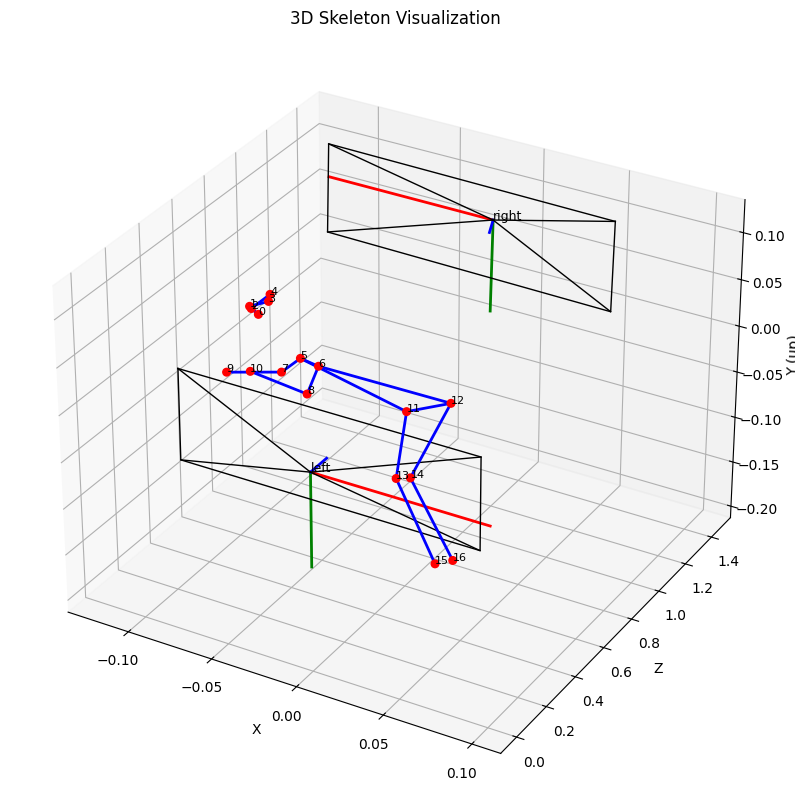

In [6]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

visualizer.draw_camera(
    ax,
	vggt_info['R'][0][0],
	vggt_info['t'][0][0],
    label="left",
)

visualizer.draw_camera(
	ax,
	vggt_info['R'][0][1],
	vggt_info['t'][0][1],
	label="right",
)

visualizer.draw_skeleton_3d(
	ax=ax,
	points_3d=vggt_info["x3d_pose"][0],
)

In [7]:
one_sample = np.load("/workspace/code/logs/vggt/2025-12-06/06-40-49/multi_view/run_3/vggt_infer/frame_0088/predictions.npz", allow_pickle=True)

In [8]:
for k, v in one_sample.items():
	print(k, type(v), v.shape if isinstance(v, np.ndarray) else '')

pose_enc <class 'numpy.ndarray'> (2, 9)
pose_enc_list <class 'numpy.ndarray'> ()
depth <class 'numpy.ndarray'> (2, 294, 518, 1)
depth_conf <class 'numpy.ndarray'> (2, 294, 518)
world_points <class 'numpy.ndarray'> (2, 294, 518, 3)
world_points_conf <class 'numpy.ndarray'> (2, 294, 518)
images <class 'numpy.ndarray'> (2, 3, 294, 518)
extrinsic <class 'numpy.ndarray'> (2, 3, 4)
intrinsic <class 'numpy.ndarray'> (2, 3, 3)
world_points_from_depth <class 'numpy.ndarray'> (2, 294, 518, 3)


In [9]:
import open3d as Open3D
import numpy as np

# 假设 P_T_dense 和 P_S_dense 仍然是 (H, W, 3) 的 NumPy 数组
P_T_dense = one_sample['world_points'][0] 
P_S_dense = one_sample['world_points'][1] 

# --- 核心修正步骤 ---

def prepare_point_cloud(dense_points: np.ndarray) -> Open3D.geometry.PointCloud:
    """将 HxWx3 的世界点云 NumPy 数组转换为 Open3D.geometry.PointCloud 对象。"""
    
    # 1. 形状を N x 3 に展平 (Flatten / Reshape)
    # H * W = N, N x 3 の配列に変換
    points_flat = dense_points.reshape(-1, 3) 
    
    # 2. 無効点 (Invalid Points) のフィルタリング
    # 世界座標が (0, 0, 0) や NaN の点は通常無効であるため、これらを除外します。
    # ここでは、ベクトルのノルムが非常に小さい点を除外する簡単なフィルタリングを使用します。
    
    # ノルム (点から原点までの距離) を計算
    norms = np.linalg.norm(points_flat, axis=1)
    
    # 有効な点 (ノルムが非常に小さい '0' に近い点ではない) を選択するマスク
    valid_mask = norms > 1e-6 
    
    valid_points = points_flat[valid_mask]

    print(f"原始点数: {len(points_flat)}, 有效点数: {len(valid_points)}")

    # 3. Open3D オブジェクトの作成
    pcd = Open3D.geometry.PointCloud()
    # 修正: Open3D の Vector3dVector コンテナを使用して点を設定
    pcd.points = Open3D.utility.Vector3dVector(valid_points)
    
    return pcd

# -------------------------- 修正後の実行部分 --------------------------

# 1. 修正後の関数を実行し、Open3D オブジェクトを正しく作成
source_pcd = prepare_point_cloud(P_S_dense)
target_pcd = prepare_point_cloud(P_T_dense)

print("\n✅ Open3D 点云对象已成功创建。")
print(f"目标点云点数 (Target): {len(target_pcd.points)}")
print(f"源点云点数 (Source): {len(source_pcd.points)}")

# ❌ 重複して誤った呼び出しを削除しました！

# ----------------------------------------------------------------------

# これで、ICP 配准に進むことができます。
max_distance = 0.5  # 最大匹配距离（根据场景的尺度调整）
initial_transform = np.identity(4) # 初始变换矩阵

print("\n开始执行 ICP 配准...")

registration_result = Open3D.pipelines.registration.registration_icp(
    source_pcd, target_pcd, max_distance, initial_transform,
    Open3D.pipelines.registration.TransformationEstimationPointToPoint(),
    Open3D.pipelines.registration.ICPConvergenceCriteria(max_iteration=200)
)

T_new_4x4 = registration_result.transformation
print(f"ICP 配准成功！变换矩阵 T (Source -> Target):\n{T_new_4x4}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
原始点数: 152292, 有效点数: 152292
原始点数: 152292, 有效点数: 152292

✅ Open3D 点云对象已成功创建。
目标点云点数 (Target): 152292
源点云点数 (Source): 152292

开始执行 ICP 配准...
ICP 配准成功！变换矩阵 T (Source -> Target):
[[ 0.99797552 -0.05554238  0.0309822   0.00232165]
 [ 0.04651928  0.96967829  0.23991658 -0.17242238]
 [-0.0433683  -0.23798961  0.97029899  0.19767461]
 [ 0.          0.          0.          1.        ]]


In [17]:
import open3d as Open3D
import numpy as np

# ----------------------------------------------
# 📌 前提条件 (前回定義したデータと関数を再利用)
# ----------------------------------------------
# P_T_dense = one_sample['world_points'][0] 
# P_S_dense = one_sample['world_points'][1] 
# prepare_point_cloud 関数は前回定義されたものを使用

# ----------------------------------------------
# 1. 点群の準備と法線の計算
# ----------------------------------------------

def prepare_pcd_with_normals(dense_points: np.ndarray, color: tuple) -> Open3D.geometry.PointCloud:
    """
    点群を準備し、色を割り当て、さらに ICP (Point-to-Plane) に必要な法線を計算する。
    """
    # prepare_point_cloud のロジックを使って pcd を作成（展平、フィルタリング、色付け）
    # 注意: ここでは prepare_point_cloud 関数内で color を設定するロジックが必要です。
    
    # 簡略化のため、pcd オブジェクトを直接作成し、フィルタリングを行う
    if dense_points.ndim == 3:
        points_flat = dense_points.reshape(-1, 3)
    else:
        points_flat = dense_points

    norms = np.linalg.norm(points_flat, axis=1)
    valid_mask = norms > 1e-6 
    valid_points = points_flat[valid_mask]
    
    pcd = Open3D.geometry.PointCloud()
    pcd.points = Open3D.utility.Vector3dVector(valid_points)
    
    # 色の割り当て (0.0 - 1.0)
    colors_array = np.full((len(valid_points), 3), color, dtype=np.float64)
    pcd.colors = Open3D.utility.Vector3dVector(colors_array)
    
    # ⭐ 核心步骤: 计算法线 (Compute Normals)
    # 法線計算のための K 近傍探索 (Radius Search)
    pcd.estimate_normals(
        search_param=Open3D.geometry.KDTreeSearchParamRadius(radius=0.1) 
        # radius の値は点群の密度とスケールに合わせて調整してください
    )
    # 法線は、点群の向きを定義し、Point-to-Plane 誤差最小化に使用される

    return pcd

# ----------------------------------------------
# 2. G-ICP (Point-to-Plane) の実行
# ----------------------------------------------

# 点群を準備（色付けは任意）
target_pcd_norm = prepare_pcd_with_normals(P_T_dense, color=(0.0, 0.0, 1.0)) # 蓝色 (Target)
source_pcd_norm = prepare_pcd_with_normals(P_S_dense, color=(1.0, 0.0, 0.0)) # 红色 (Source)

max_distance = 0.5  # 最大匹配距离（根据场景的尺度调整）
initial_transform = np.identity(4) 

print("\n开始执行 G-ICP (Point-to-Plane) 配准...")

registration_result = Open3D.pipelines.registration.registration_icp(
    source_pcd_norm, target_pcd_norm, max_distance, initial_transform,
    # ⭐ 変更点: Point-to-Plane 誤差推定を使用
    Open3D.pipelines.registration.TransformationEstimationPointToPlane(),
    Open3D.pipelines.registration.ICPConvergenceCriteria(max_iteration=200)
)

T_new_GICP_4x4 = registration_result.transformation
print(f"G-ICP (Point-to-Plane) 配准成功！变换矩阵 T:\n{T_new_GICP_4x4}")

# ----------------------------------------------
# 3. 結果の可視化
# ----------------------------------------------

# Source 点群に G-ICP の結果を適用
source_pcd_aligned_GICP = source_pcd_norm.transform(T_new_GICP_4x4)
source_pcd_aligned_GICP.paint_uniform_color([0.0, 1.0, 0.0]) # 绿色 (Aligned)

print("\n结果可视图: 蓝色 (Target), 红色 (Source Original), 绿色 (Source Aligned)")

# 可視化
Open3D.visualization.draw_geometries([target_pcd_norm, source_pcd_norm, source_pcd_aligned_GICP])


开始执行 G-ICP (Point-to-Plane) 配准...
G-ICP (Point-to-Plane) 配准成功！变换矩阵 T:
[[ 0.97675206  0.05130842 -0.20814143 -0.24540318]
 [-0.02668774  0.99248548  0.11941665 -0.05234264]
 [ 0.21270442 -0.11108564  0.97078155  0.16516937]
 [ 0.          0.          0.          1.        ]]

结果可视图: 蓝色 (Target), 红色 (Source Original), 绿色 (Source Aligned)


error: XDG_RUNTIME_DIR not set in the environment.


In [11]:
# 假设 T_new_4x4 已经从 ICP 配准结果中获得
# T_new_4x4 = registration_result.transformation 

# ----------------------------------------------
# 1. 提取上一帧的绝对位姿 T_prev
# ----------------------------------------------

# extrinsic[0] 是上一帧 (t-1) 的 3x4 外参 [R | t]
extrinsic_prev_3x4 = one_sample['extrinsic'][0]

# 将 3x4 矩阵转换为 4x4 齐次变换矩阵 T_prev
# T_prev = [[R, t], [0, 1]]
T_prev = np.identity(4)
T_prev[:3, :] = extrinsic_prev_3x4 

print(f"上一帧的绝对位姿 T_prev (4x4):\n{T_prev}")

# ----------------------------------------------
# 2. 计算相机的相对运动 T_rel = T_new^-1
# ----------------------------------------------

# T_new 是 Source -> Target 的变换
# T_new_inv 是 Target -> Source 的相对运动 T_rel
T_rel = np.linalg.inv(T_new_4x4)

# ----------------------------------------------
# 3. 计算当前帧的绝对位姿 T_current
# ----------------------------------------------

# T_current = T_prev @ T_rel
T_current = T_prev @ T_rel

print(f"\n当前帧的绝对位姿 T_current (4x4):\n{T_current}")

# ----------------------------------------------
# 4. 更新 extrinsic[1]
# ----------------------------------------------

# extrinsic[1] 需要 T_current 的 3x4 部分
updated_extrinsic_1 = T_current[:3, :]

print(f"\n更新后的 extrinsic[1] (3x4):\n{updated_extrinsic_1}")

# (可选) 将更新后的外参存回原始数据结构
# one_sample['extrinsic'][1] = updated_extrinsic_1

上一帧的绝对位姿 T_prev (4x4):
[[ 1.00000000e+00 -2.32274382e-04 -6.89212611e-05 -1.52030389e-05]
 [ 2.32266757e-04  9.99999940e-01 -1.10796325e-04 -2.95059526e-05]
 [ 6.89469962e-05  1.10780304e-04  1.00000000e+00 -1.30546847e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

当前帧的绝对位姿 T_current (4x4):
[[ 0.99798629  0.04627751 -0.0433799   0.01422221]
 [-0.05531401  0.96966246 -0.23810717  0.21435816]
 [ 0.03104485  0.24002721  0.97026964 -0.15061423]
 [ 0.          0.          0.          1.        ]]

更新后的 extrinsic[1] (3x4):
[[ 0.99798629  0.04627751 -0.0433799   0.01422221]
 [-0.05531401  0.96966246 -0.23810717  0.21435816]
 [ 0.03104485  0.24002721  0.97026964 -0.15061423]]


In [12]:
import numpy as np

# ----------------------------------------------
# 前のステップで計算された 4x4 変換行列を想定:
# ----------------------------------------------
# T_current = T_prev @ T_rel 
# T_current は NumPy ndarray で、形状は (4, 4) です。
# 例として、ランダムな行列を使用します（実際のT_currentに置き換えてください）：
T_current = updated_extrinsic_1

# ----------------------------------------------
# R と t の抽出
# ----------------------------------------------

# 1. R (回転行列) の抽出: 左上 3x3 のブロック
R = T_current[0:3, 0:3]

# 2. t (平移ベクトル) の抽出: 右上の 3x1 の列
t = T_current[0:3, 3]

# ----------------------------------------------
# 結果の表示
# ----------------------------------------------
print("--- 抽出結果 ---")
print(f"✅ R (回転行列) の形状: {R.shape}")
print(R)
print("-" * 20)
print(f"✅ t (平移ベクトル) の形状: {t.shape}")
print(t)

--- 抽出結果 ---
✅ R (回転行列) の形状: (3, 3)
[[ 0.99798629  0.04627751 -0.0433799 ]
 [-0.05531401  0.96966246 -0.23810717]
 [ 0.03104485  0.24002721  0.97026964]]
--------------------
✅ t (平移ベクトル) の形状: (3,)
[ 0.01422221  0.21435816 -0.15061423]


In [13]:
# P_S_dense は (H, W, 3) の源点群 (NumPy)
# T_new_4x4 は ICP 配准で得られた Source -> Target の 4x4 変換行列

# 1. N x 3 に展平
points_flat_S = P_S_dense.reshape(-1, 3) 

# 2. 有効点のみを選択 (prepare_point_cloud 関数で行った処理を再現)
norms = np.linalg.norm(points_flat_S, axis=1)
valid_mask = norms > 1e-6 
valid_points_S = points_flat_S[valid_mask]

# 3. N x 4 の斉次座標に変換 (最後の列に 1 を追加)
ones = np.ones((valid_points_S.shape[0], 1), dtype=valid_points_S.dtype)
P_S_homo = np.hstack([valid_points_S, ones])

# 4. 変換を適用 (P_T_homo = P_S_homo @ T_new.T)
# NumPy での処理は転置が必要です: (N x 4) @ (4 x 4)
P_T_homo = P_S_homo @ T_new_4x4.T 

# 5. デカルト座標に戻す (最後の列を削除)
P_T_aligned = P_T_homo[:, :3]

# 6. 元のデータ構造に反映 (必要であれば)
# P_T_aligned は有効点のみなので、元の H x W x 3 形状に戻すのは複雑です。
# 代わりに、新しい点群として保存するか、元の配列の有効な位置を更新します。
# 例: 最初の有効な点
print(f"変換された点群の最初の点:\n{P_T_aligned[0]}")

変換された点群の最初の点:
[-0.4030151  -0.37498246  0.78745364]


In [14]:
import open3d as Open3D
import numpy as np

# ----------------------------------------------
# 📌 前提条件 (ダミーデータ): 実際には P_T_aligned などに置き換えてください
# ----------------------------------------------
# P_T_dense, P_S_dense, P_T_aligned は NumPy ndarray (N x 3 or H x W x 3)
# 例として、ランダムなデータとダミーの P_T_aligned を作成
H, W = 100, 100
N = H * W
P_S_dense = P_S_dense
P_T_dense = P_T_dense
# P_T_aligned は ICP 配准で変換された点群（N x 3 形状を想定）
P_T_aligned = P_T_aligned


# ----------------------------------------------
# 🛠️ ユーティリティ関数: 点群の準備
# ----------------------------------------------

def prepare_point_cloud(dense_points: np.ndarray, color: tuple) -> Open3D.geometry.PointCloud:
    """
    点群データを Open3D オブジェクトに変換し、無効点をフィルタリングし、色を割り当てる。
    
    Args:
        dense_points: HxWx3 または Nx3 形状の NumPy 配列。
        color: (R, G, B) のタプル (0.0 から 1.0 の浮動小数点数)。
    
    Returns:
        Open3D.geometry.PointCloud: 処理後の点群オブジェクト。
    """
    if dense_points.ndim == 3:
        # HxWx3 を Nx3 に展平
        points_flat = dense_points.reshape(-1, 3)
    elif dense_points.ndim == 2 and dense_points.shape[1] == 3:
        points_flat = dense_points
    else:
        raise ValueError("输入点群的形状必须是 HxWx3 或 Nx3。")

    # 無効点 (原点に近い点) のフィルタリング
    norms = np.linalg.norm(points_flat, axis=1)
    valid_mask = norms > 1e-6 
    valid_points = points_flat[valid_mask]

    # Open3D オブジェクトの作成
    pcd = Open3D.geometry.PointCloud()
    pcd.points = Open3D.utility.Vector3dVector(valid_points)
    
    # 色の割り当て
    num_points = len(valid_points)
    colors_array = np.full((num_points, 3), color, dtype=np.float64)
    pcd.colors = Open3D.utility.Vector3dVector(colors_array)
    
    print(f"有效点数: {num_points}")
    return pcd

# ----------------------------------------------
# 🎨 実行と可視化
# ----------------------------------------------

# 1. ターゲット点群 (P_T_dense): 最終参照点群（青）
pcd_target = prepare_point_cloud(P_T_dense, color=(0.0, 0.0, 1.0)) # 蓝色

# 2. ソース点群 (P_S_dense): 変換前の点群（赤）
# ICP 配准を実行する前の、元の位置にある点群
pcd_source_original = prepare_point_cloud(P_S_dense, color=(1.0, 0.0, 0.0)) # 红色

# 3. 変換後の点群 (P_T_aligned): ICP 配准によりターゲットに整列された点群（緑）
# これが更新された位姿を反映した点群です
# P_T_aligned は既に Nx3 形状と仮定
pcd_aligned = prepare_point_cloud(P_T_aligned, color=(0.0, 1.0, 0.0)) # 绿色

print("\n--- 可视化设置完成 ---")

# 4. 3 つの点群を可視化
# 青 (Target) に対して、赤 (Original Source) がどこにあり、緑 (Aligned Source) がいかに一致しているかを確認
Open3D.visualization.draw_geometries([pcd_target, pcd_source_original, pcd_aligned],
                                     window_name="Point Cloud Alignment Visualization",
                                     width=800, height=600)

有效点数: 152292
有效点数: 152292
有效点数: 152292

--- 可视化设置完成 ---


error: XDG_RUNTIME_DIR not set in the environment.


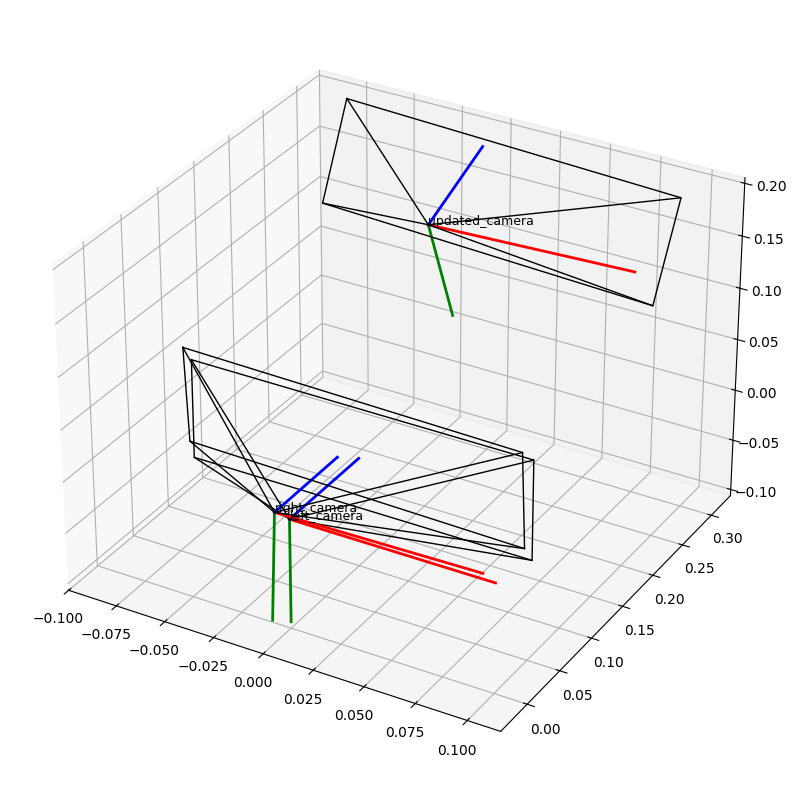

In [18]:
from vggt.vis.skeleton_visualizer import SkeletonVisualizer

visualizer = SkeletonVisualizer()

left_extrinscit = one_sample['extrinsic'][0]
right_extrinscit = one_sample['extrinsic'][1]


left_R = left_extrinscit[:, 0:3]
left_t = left_extrinscit[:, 3]

right_R = right_extrinscit[:, 0:3]
right_t = right_extrinscit[:, 3]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

visualizer.draw_camera(
	ax=ax,
	R=left_R,
	T=left_t,
	label="left_camera",
)

visualizer.draw_camera(
	ax=ax,
	R=right_R,
	T=right_t,
	label="right_camera",
)

visualizer.draw_camera(
	ax=ax,
	R=R,
	T=t,
	label="updated_camera",
)

plt.show()